Structured variational message passing demo
===

A generalization of VMP under the mean field approximation is structured VMP (SVMP). SVMP allows arbitrary factorizations of the approximating $q$ distribution (Dauwels 2007). As an example case to illustrate and test our SVMP implementation in ForneyLab, we estimate the mean $m$ and precision $\gamma$ for a set of samples $y = \{y_1, ..., y_k, ..., y_n\}$ drawn from a Gaussian distribution.

The factor graph below shows our generative model, where we use the notation of (Reller, 2012; State-space methods in statistical signal processing). Filled black nodes represent observed variables and dotted arcs denote the repetition of a section.

<img src="images/gauss_est_prec.png">

This is the same model as in the previous demo, however this time we use precision parametrization and factorize the approximating distribution as $q(m,\gamma,y)=q(m,\gamma)\,q(y)$. Also, we estimate the mean and precision in a sample-by sample (online) fashion instead of in bulk.

We begin by implementing the factor graph in ForneyLab and define the structured factoriation.

In [1]:
using(ForneyLab)

# Initialize nodes and edges
GaussianNode(id=:g, form=:precision)
EqualityNode(id=:m_eq) # Equality node for mean
EqualityNode(id=:gam_eq) # Equality node for precision
TerminalNode(id=:y) # Observed y values are stored in y_node
PriorNode(GaussianDistribution(m=0.0, V=100.0), id=:m_n_min_1) # Prior
PriorNode(GammaDistribution(a=0.01, b=0.01), id=:gam_n_min_1) # Prior
TerminalNode(vague(GaussianDistribution), id=:m_n)
TerminalNode(vague(GammaDistribution), id=:gam_n)

Edge(n(:g).i[:out], n(:y), GaussianDistribution)
Edge(n(:m_eq).i[3], n(:g).i[:mean], GaussianDistribution)
Edge(n(:gam_eq).i[3], n(:g).i[:precision], GammaDistribution)
Edge(n(:m_n_min_1), n(:m_eq).i[1], GaussianDistribution)
Edge(n(:gam_n_min_1), n(:gam_eq).i[1], GammaDistribution)
Edge(n(:m_eq).i[2], n(:m_n), GaussianDistribution)
Edge(n(:gam_eq).i[2], n(:gam_n), GammaDistribution)

# Set wraps
wrap(n(:m_n), n(:m_n_min_1))
wrap(n(:gam_n), n(:gam_n_min_1));

Now we need to specify the factorization, update schedules for both subgraphs and set the vague (almost uninformative) marginals.


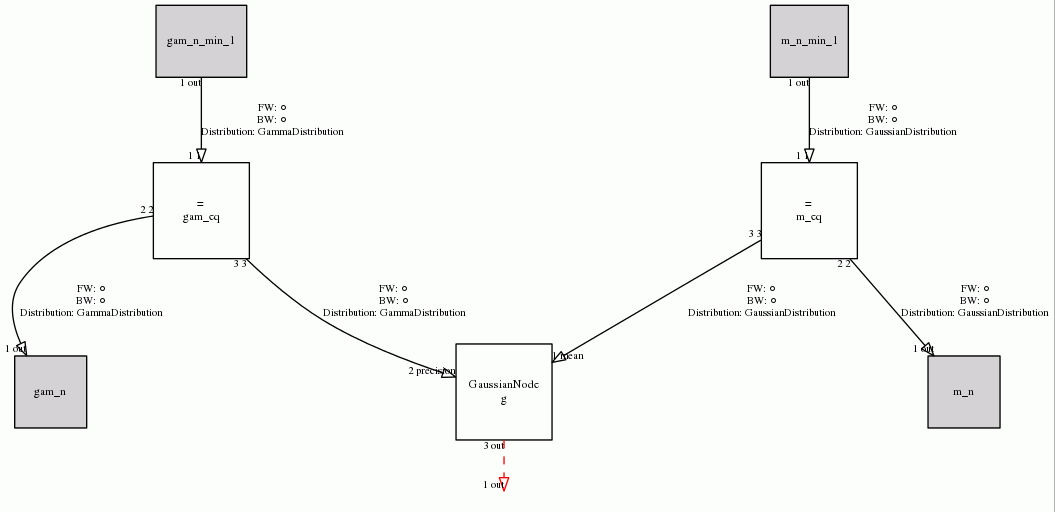


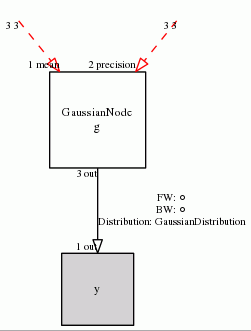

In [2]:
# Generate some data
true_mean = 5.0
true_prec = 0.5
n_samples = 100 # Draw 100 samples
n_its = 10 # Iterations per data sample
y_vals = randn(n_samples)*(1/sqrt(true_prec))+true_mean
data = [DeltaDistribution(y) for y in y_vals]

# Add read and write buffers
y_buffer = setReadBuffer(n(:y), data)
m_est = setWriteBuffer(n(:m_eq).i[2])
gam_est = setWriteBuffer(n(:gam_eq).i[2])

# Define the structured variational algorithm
algo = VMP.Algorithm(Set{Edge}({n(:g).i[:out].edge}), n_iterations=n_its)

# Inspect the factorization (optional)
for subgraph in algo.fields[:factorization].factors
    draw(subgraph)
end

Now the setup is done and we can start the iterations.

In [3]:
run(algo)

Let's inspect the results.

In [4]:
println("True mean: $(true_mean)")
println("True precision: $(true_prec)")
println("Number of samples: $(n_samples)")
println("Sample mean: $(round(mean(y_vals),2))")
println("Sample precision: $(round(1/var(y_vals),2))")
println("\n----- Online estimation after $(n_its) VMP updates per sample -----")
println("Mean estimate: $(round(mean(m_est[end])[1],2)), with variance $(round(var(m_est[end])[1,1],2))")
println("Precision estimate: $(round(mean(gam_est[end]),2)), with variance $(round(var(gam_est[end]),2))")

True mean: 5.0
True precision: 0.5
Number of samples: 100
Sample mean: 4.98
Sample precision: 0.42

----- Online estimation after 10 VMP updates per sample -----
Mean estimate: 4.86, with variance 0.04
Precision estimate: 0.34, with variance 0.0
